In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#test pretrained medical word2vec
from gensim.models.keyedvectors import KeyedVectors
gensim_model = KeyedVectors.load_word2vec_format(
    '/Volumes/Ke/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True, limit=300000)

In [23]:
print(gensim_model.similarity('sick', 'great'))

0.40434145886451833


In [88]:
vocab = gensim_model.vocab.keys()
print(len(vocab))
gensim_model.wv.vocab
print('hello =', gensim_model['hello'].shape)

hello = (200,)


### Load data

In [2]:
df = pd.read_csv("adm_notes_exclude_dead_readm_updated.csv",
                     header=0)
df.columns
df.shape

(1316, 27)

In [4]:
data = pd.DataFrame()
data['label'] = (df['redays']<=30).astype('int')
data['summary'] = df['summary']
data.label.value_counts()
data_dropna=data.dropna()
data_dropna['label'].value_counts()

0    1146
1     154
Name: label, dtype: int64

### Text preprocess

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
import string

In [6]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df = df.fillna(' ')
    df =df.str.replace('\n',' ')
    df =df.str.replace('\r',' ')
    return df

# def tokenizer_better(text):
#     # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
#     punc_list = string.punctuation+'0123456789'
#     t = str.maketrans(dict.fromkeys(punc_list, " "))
#     text = text.lower().translate(t)
#     tokens = word_tokenize(text)
#     return text

my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','t','that']

data_dropna['x_pre'] = preprocess_text(data_dropna['summary'])
#data_dropna['x_pre'] = tokenizer_better(data_dropna['x_pre'].to_string())
# data_dropna['x_tokens'] = tokenizer_better(data_dropna['x_pre'].to_string())
# vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better, stop_words = my_stop_words)
# # # this could take a while
# data_dropna['x_input'] = vect.fit_transform(data_dropna['summary'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
import sys,os,re,csv,codecs,numpy as np,pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,LSTM,Embedding
from keras.layers import Dropout,Activation
from keras.layers import Bidirectional,GlobalMaxPool1D
from keras.models import Model
import gc
import gensim.models.keyedvectors as word2vec

Using TensorFlow backend.
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


In [8]:
list_sentences = data_dropna['x_pre']
# Number of Most frequence words
max_features = 20000

tokenizer = Tokenizer(num_words = max_features)

tokenizer.fit_on_texts(list(list_sentences))
# Tokenize each summary into indices sequence
list_sentences_step2 = tokenizer.texts_to_sequences(list_sentences)

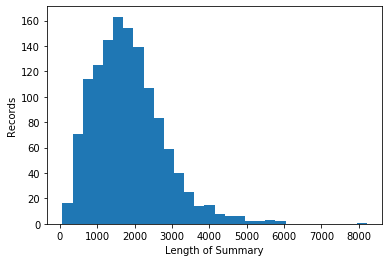

In [10]:
max_length = [len(row) for row in list_sentences_step2]
import matplotlib.pyplot as plt
#Looking at the distribution of length of stay
plt.hist(max_length, bins = 30)
plt.xlabel('Length of Summary')
plt.ylabel('Records')
plt.show()

In [64]:
#可以看到长度是不一样的，因此我们需要转化为等长列表。转化为2D numpy array。大多数的长度都在3000以内，所以取3000，防止矩阵稀疏
maxlen = 3000 # 列长度
X = pad_sequences(list_sentences_step2,maxlen = maxlen)
X.shape

(1300, 3000)

In [12]:
# 构建词向量
def loadEMbeddingMatrix():
    from gensim.models.keyedvectors import KeyedVectors
    word2vecDict = KeyedVectors.load_word2vec_format(
    '/Volumes/Ran/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True, limit=300000)
    embed_size = 200
    embedding_index = dict()
    # 词与对应词向量
    for word in word2vecDict.wv.vocab:
        embedding_index[word] = word2vecDict.word_vec(word) # 对应的(200,)的词向量
    print('Load %s word vectors.' % len(embedding_index))
    gc.collect()
    all_embs = np.stack(list(embedding_index.values())) # （3000000,200）
    emb_mean,emb_std = all_embs.mean(),all_embs.std()
    nb_words = len(tokenizer.word_index) # 训练词的个数
#     print(emb_mean,emb_std,nb_words)
    # 权重矩阵随机初始化
    embedding_matrix = np.random.normal(emb_mean,emb_std,(nb_words,embed_size))
    gc.collect()
    embeddedCount = 0
    wordnub = 0
    outofVocal =[]
    for word,i in tokenizer.word_index.items(): # 词
        i -= 1
        wordnub += 1
        embedding_vector = embedding_index.get(word)
#         print(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            embeddedCount += 1
        else:
            outofVocal.append(word)  
    print('total_embedded:',embeddedCount,'commen words', 'total words:', wordnub)
    del embedding_index
    gc.collect()
    return embedding_matrix,outofVocal


#### in all summaries, there are 29859 tokens, when we load 300000 word vectors from pretrained embedding, there are 20919 common words can be found in word vectors, out of vocab is printed.

In [13]:
embedding_matrix,outofv = loadEMbeddingMatrix()
embedding_matrix.shape

/opt/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Load 300000 word vectors.
total_embedded: 20919 commen words total words: 29859


(29859, 200)

#### Notice there are a lot numerical data and typos in outofv, so the next step could be clean the summary a little bit by removing numbers and replacing typos.

In [16]:
outofv

['hospital1',
 'stitle',
 'namepattern1',
 'name8',
 'lastname',
 'name3',
 'namepattern4',
 'namepattern2',
 'hospital3',
 'cannot',
 'name6',
 '00am',
 'hospital6',
 'nameis',
 '00pm',
 'name11',
 '30pm',
 '30am',
 'pattern1',
 'name10',
 'name2',
 '15am',
 '20am',
 'firstname',
 '40pm',
 'name4',
 '45am',
 '40am',
 '50pm',
 '45pm',
 '25am',
 '50am',
 'basos',
 'name9',
 '55am',
 '05pm',
 '35am',
 'urobilngn',
 'barbitr',
 '25pm',
 'bnzodzp',
 '4267',
 '4268',
 '05am',
 'parieto',
 'bnzodzpn',
 'barbitrt',
 'urobiln',
 'bilirub',
 '35pm',
 '58am',
 'acetmnp',
 'tricycl',
 'caltco2',
 'phenyto',
 'name5',
 '55pm',
 'mthdone',
 '5018',
 '5023',
 '37am',
 'bacteri',
 'freeca',
 'ptitle',
 '14am',
 "c'd",
 '08am',
 '53am',
 '22am',
 '01am',
 '13am',
 '48am',
 'indx',
 '47am',
 '31am',
 '06am',
 '52am',
 '21am',
 '03am',
 '08pm',
 '04am',
 '26am',
 '4296',
 '32am',
 '28am',
 '46am',
 '52pm',
 '07am',
 '51am',
 '48pm',
 '59am',
 'amphetmn',
 '9381',
 'intubat',
 'name13',
 '46pm',
 '43am',

### Build BiLSTM Model

In [26]:
from keras import optimizers
from keras import backend as K
import tensorflow as tf

# All parameter gradients will be clipped to
# a maximum value of 0.5 and
# a minimum value of -0.5.

def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed


def _model(maxlen,embedding_matrix,units):
    inp = Input(shape = (maxlen,))
    x = Embedding(units,embedding_matrix.shape[1],weights = [embedding_matrix],
                 trainable = False)(inp)
    x = Bidirectional(LSTM(30,return_sequences=True,name = 'lstm_layer',
                         dropout=0.5,recurrent_dropout=0.5))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.5)(x)
    x = Dense(32,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2,activation='softmax')(x)
    model = Model(inputs = inp,outputs = x)
    optimizer_adam = optimizers.Adam(learning_rate=1e-6, beta_1=0.89, beta_2=0.999, amsgrad=False)
    model.compile(loss = [binary_focal_loss(alpha=.25, gamma=3)],
                 optimizer = optimizer_adam,
                 metrics = ['accuracy'])
    return model


In [27]:
print(len(tokenizer.word_index),embedding_matrix.shape[1],maxlen)

29859 200 3000


In [28]:
embedding_matrix.shape

(29859, 200)

In [29]:
model = _model(units = len(tokenizer.word_index),embedding_matrix=embedding_matrix,maxlen=maxlen)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 3000, 200)         5971800   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3000, 60)          55440     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1952      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0   

#### Stratify the training and test dataset

In [23]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit

y = data_dropna['label']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0) 

for train_index, test_index in sss.split(X, y):
    max_len = len(X)
    train_index = train_index[train_index < max_len]
    test_index = test_index[test_index < max_len]
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
y_test = np.asarray(y_test).astype(np.int)
y_test[y_test < 0] = 0
y_test = to_categorical(y_test)
y_train = np.asarray(y_train).astype(np.int)
y_train[y_train < 0] = 0
y_train = to_categorical(y_train)

TRAIN: [ 182  437 1198 ...  826  529  896] TEST: [1227  226 1054  773  870  430   96 1084  855  413  315  656 1005  613
  866 1272 1048 1175  475  425  143  121  252   11 1038  507  876  104
  897  383 1243  731  986  827  802   82  585   95   94 1136  109  673
  687  666   24  441  760  357  665  877  846  857  342  621 1032 1207
  709 1210  981 1004  564  604  408  583 1092  156 1294  677  797  882
  707   92 1202   44  344  334  134  355  749  628  943  664  371  188
  145  268  811  128  280  596  493  166  321  360  599  541  490  961
 1093  136  489   61 1169  822  301  511  581  431  414  612   14 1081
   30  468 1142  483 1028  284 1254  100  519  864  168  311   27   34
 1181  224  845 1029  906  561  777  787  620  921  747 1083  875  661
 1256 1102  996 1146  108  200 1213  894  603  126  901  947  418  356
 1002 1057  950  660  230  410  310  298  955 1287  952 1103  757 1140
  335  774  838  937  910 1106 1076  495  623  232  957  194  299  701
  169  616  963   78 1233  1

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


#### experienment on default adam optimizer, dropout = 0.3


Fold  1


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 939 samples, validate on 166 samples
Epoch 1/3
939/939 [==============================] - 114s 122ms/step - loss: 0.4795 - accuracy: 0.5170 - val_loss: 0.5093 - val_accuracy: 0.8855
Epoch 2/3
939/939 [==============================] - 107s 114ms/step - loss: 0.3123 - accuracy: 0.5612 - val_loss: 0.6540 - val_accuracy: 0.8855
Epoch 3/3
939/939 [==============================] - 107s 114ms/step - loss: 0.2411 - accuracy: 0.5495 - val_loss: 0.6938 - val_accuracy: 0.4518


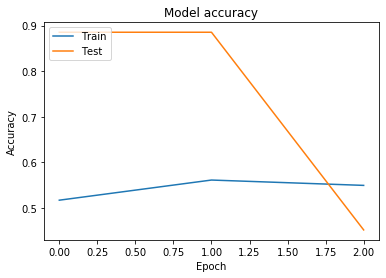

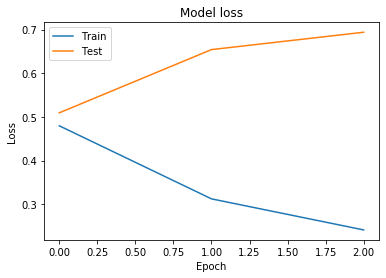

166/166 [==============================] - 6s 34ms/step
[0.6937640093895326, 0.4518072307109833]

Fold  2
Train on 939 samples, validate on 166 samples
Epoch 1/3
939/939 [==============================] - 101s 107ms/step - loss: 0.2324 - accuracy: 0.5101 - val_loss: 0.7104 - val_accuracy: 0.1325
Epoch 2/3
939/939 [==============================] - 103s 110ms/step - loss: 0.2078 - accuracy: 0.5005 - val_loss: 0.6985 - val_accuracy: 0.2892
Epoch 3/3
939/939 [==============================] - 103s 110ms/step - loss: 0.2060 - accuracy: 0.5186 - val_loss: 0.6979 - val_accuracy: 0.2410


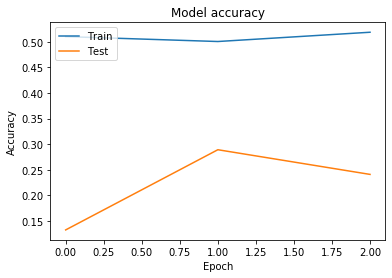

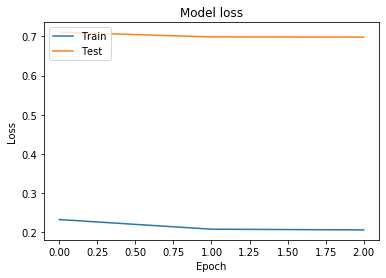

166/166 [==============================] - 5s 32ms/step
[0.6979337033019009, 0.2409638613462448]

Fold  3
Train on 939 samples, validate on 166 samples
Epoch 1/3
939/939 [==============================] - 106s 113ms/step - loss: 0.2036 - accuracy: 0.4920 - val_loss: 0.6926 - val_accuracy: 0.5663
Epoch 2/3
939/939 [==============================] - 100s 106ms/step - loss: 0.1805 - accuracy: 0.4760 - val_loss: 0.6896 - val_accuracy: 0.8554
Epoch 3/3
939/939 [==============================] - 107s 114ms/step - loss: 0.1786 - accuracy: 0.5857 - val_loss: 0.6884 - val_accuracy: 0.8855


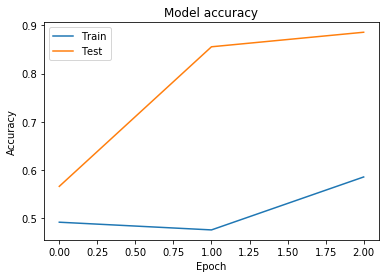

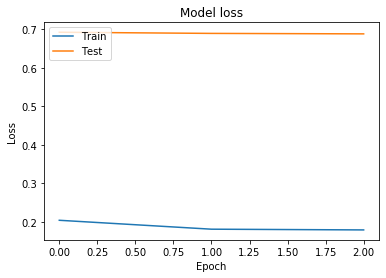

166/166 [==============================] - 5s 32ms/step
[0.6884231739733593, 0.8855421543121338]


In [22]:

sss = StratifiedShuffleSplit(n_splits=3, test_size=0.15, random_state=0) 
j = 1
for train_index, test_index in sss.split(X_train, y_train):
    print('\nFold ',j)
    j +=1
    max_len = len(X)
    train_index = train_index[train_index < max_len]
    test_index = test_index[test_index < max_len]
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_valid_cv = X[train_index], X[test_index]
    y_train_cv, y_valid_cv = y[train_index], y[test_index]
    
    
    
    y_valid_cv = np.asarray(y_valid_cv).astype(np.int)
    y_valid_cv[y_valid_cv < 0] = 0
    y_valid_cv = to_categorical(y_valid_cv)
    y_train_cv = np.asarray(y_train_cv).astype(np.int)
    y_train_cv[y_train_cv < 0] = 0
    y_train_cv = to_categorical(y_train_cv)



    class_weight = {0: 0.15,
                   1: 0.85}
    batch_size = 64
    epochs = 3

    history = model.fit(X_train_cv,y_train_cv, batch_size=batch_size, epochs=epochs, 
                        validation_data = (X_valid_cv, y_valid_cv),
                        class_weight=class_weight)
    
    import matplotlib.pyplot as plt

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print(model.evaluate(X_valid_cv, y_valid_cv))



Fold  1
Train on 939 samples, validate on 166 samples
Epoch 1/30


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


939/939 [==============================] - 69s 74ms/step - loss: 10.2327 - accuracy: 0.3727 - val_loss: 19.4238 - val_accuracy: 0.1145
Epoch 2/30
939/939 [==============================] - 67s 71ms/step - loss: 10.8819 - accuracy: 0.3749 - val_loss: 19.4105 - val_accuracy: 0.1145
Epoch 3/30
939/939 [==============================] - 67s 71ms/step - loss: 11.2803 - accuracy: 0.3759 - val_loss: 19.3968 - val_accuracy: 0.1145
Epoch 4/30
939/939 [==============================] - 74s 79ms/step - loss: 10.1844 - accuracy: 0.3546 - val_loss: 19.3832 - val_accuracy: 0.1145
Epoch 5/30
939/939 [==============================] - 67s 72ms/step - loss: 10.0713 - accuracy: 0.3855 - val_loss: 19.3699 - val_accuracy: 0.1145
Epoch 6/30
939/939 [==============================] - 67s 72ms/step - loss: 11.0985 - accuracy: 0.3834 - val_loss: 19.3564 - val_accuracy: 0.1145
Epoch 7/30
939/939 [==============================] - 71s 76ms/step - loss: 11.1944 - accuracy: 0.3813 - val_loss: 19.3426 - val_accura

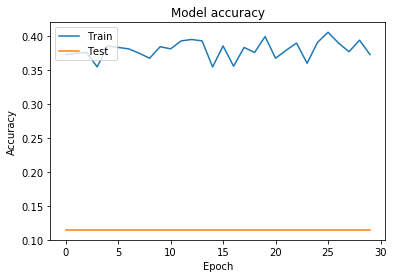

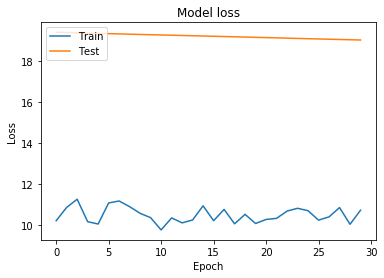

166/166 [==============================] - 4s 23ms/step
[10.321157927972724, 0.11445783078670502]

Fold  2
Train on 939 samples, validate on 166 samples
Epoch 1/30
939/939 [==============================] - 65s 69ms/step - loss: 10.2264 - accuracy: 0.3802 - val_loss: 19.8197 - val_accuracy: 0.0964
Epoch 2/30
939/939 [==============================] - 64s 68ms/step - loss: 10.8664 - accuracy: 0.3589 - val_loss: 19.8060 - val_accuracy: 0.0964
Epoch 3/30
939/939 [==============================] - 63s 67ms/step - loss: 10.9440 - accuracy: 0.3749 - val_loss: 19.7923 - val_accuracy: 0.0964
Epoch 4/30
939/939 [==============================] - 65s 69ms/step - loss: 10.9777 - accuracy: 0.3419 - val_loss: 19.7785 - val_accuracy: 0.0964
Epoch 5/30
939/939 [==============================] - 63s 67ms/step - loss: 10.3664 - accuracy: 0.3695 - val_loss: 19.7652 - val_accuracy: 0.0964
Epoch 6/30
939/939 [==============================] - 64s 68ms/step - loss: 11.2475 - accuracy: 0.3621 - val_loss: 19

KeyboardInterrupt: 

In [158]:
#experiment on learning_rate=1e-7
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.15, random_state=0) 
j = 1
for train_index, test_index in sss.split(X_train, y_train):
    print('\nFold ',j)
    j +=1
    max_len = len(X)
    train_index = train_index[train_index < max_len]
    test_index = test_index[test_index < max_len]
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_valid_cv = X[train_index], X[test_index]
    y_train_cv, y_valid_cv = y[train_index], y[test_index]
    
    
    
    y_valid_cv = np.asarray(y_valid_cv).astype(np.int)
    y_valid_cv[y_valid_cv < 0] = 0
    y_valid_cv = to_categorical(y_valid_cv)
    y_train_cv = np.asarray(y_train_cv).astype(np.int)
    y_train_cv[y_train_cv < 0] = 0
    y_train_cv = to_categorical(y_train_cv)



    class_weight = {0: 0.15,
                   1: 0.85}
    batch_size = 64
    epochs = 30

    history = model.fit(X_train_cv,y_train_cv, batch_size=batch_size, epochs=epochs, 
                        validation_data = (X_valid_cv, y_valid_cv),
                        class_weight=class_weight)
    
    import matplotlib.pyplot as plt

    #history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print(model.evaluate(X_valid_cv, y_valid_cv))

    
#     folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))
    
#     return folds, X_train, y_train

# k = 3
# folds, X_train, y_train = load_data_kfold(k, X_train, y_train)

# for j, (train_idx, val_idx) in enumerate(folds):
    
#     print('\nFold ',j)
#     X_train_cv = X_train[train_idx]
#     y_train_cv = y_train[train_idx]
#     X_valid_cv = X_train[val_idx]
#     y_valid_cv= y_train[val_idx]
    
#     name_weights = "final_model_fold" + str(j) + "_weights.h5"
#     callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
#     generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
#     model = get_model()
#     model.fit_generator(
#                 generator,
#                 steps_per_epoch=len(X_train_cv)/batch_size,
#                 epochs=15,
#                 shuffle=True,
#                 verbose=1,
#                 validation_data = (X_valid_cv, y_valid_cv),
#                 callbacks = callbacks)
    
#     print(model.evaluate(X_valid_cv, y_valid_cv))

In [29]:
loss, acc = model.evaluate(X_valid_cv, y_valid_cv)

166/166 [==============================] - 7s 42ms/step


In [30]:
loss, acc

(0.5147364448352032, 0.8855421543121338)

In [24]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

print(classification_report(y_test2, y_pred_bool))

195/195 [==============================] - 9s 47ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       176
           1       0.00      0.00      0.00        19

    accuracy                           0.90       195
   macro avg       0.45      0.50      0.47       195
weighted avg       0.81      0.90      0.86       195



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test2, y_pred_bool)

array([[176,   0],
       [ 19,   0]])

#### experiment on learning_rate=1e-4, this learning rate is too high, since the validation accuracy is stuck at 0.8855, in this point the NN predict all test data as negative.

In [25]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.15, random_state=0) 
j = 1
for train_index, test_index in sss.split(X_train, y_train):
    print('\nFold ',j)
    j +=1
    max_len = len(X)
    train_index = train_index[train_index < max_len]
    test_index = test_index[test_index < max_len]
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_valid_cv = X[train_index], X[test_index]
    y_train_cv, y_valid_cv = y[train_index], y[test_index]
    
    
    
    y_valid_cv = np.asarray(y_valid_cv).astype(np.int)
    y_valid_cv[y_valid_cv < 0] = 0
    y_valid_cv = to_categorical(y_valid_cv)
    y_train_cv = np.asarray(y_train_cv).astype(np.int)
    y_train_cv[y_train_cv < 0] = 0
    y_train_cv = to_categorical(y_train_cv)



    class_weight = {0: 0.15,
                   1: 0.85}
    batch_size = 64
    epochs = 300

    history = model.fit(X_train_cv,y_train_cv, batch_size=batch_size, epochs=epochs, 
                        validation_data = (X_valid_cv, y_valid_cv),
                        class_weight=class_weight)
    
    import matplotlib.pyplot as plt

    #history = model.fit(x, y, validation_split=0.25, epochs=50, batch_size=16, verbose=1)

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print(model.evaluate(X_valid_cv, y_valid_cv))



Fold  1
Train on 939 samples, validate on 166 samples
Epoch 1/300


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


939/939 [==============================] - 67s 72ms/step - loss: 5.2516 - accuracy: 0.5421 - val_loss: 3.1198 - val_accuracy: 0.8855
Epoch 2/300
939/939 [==============================] - 65s 69ms/step - loss: 3.6741 - accuracy: 0.6155 - val_loss: 3.3280 - val_accuracy: 0.8855
Epoch 3/300
939/939 [==============================] - 65s 69ms/step - loss: 2.8379 - accuracy: 0.7157 - val_loss: 3.8622 - val_accuracy: 0.8855
Epoch 4/300
939/939 [==============================] - 64s 68ms/step - loss: 2.3715 - accuracy: 0.7146 - val_loss: 4.0082 - val_accuracy: 0.8855
Epoch 5/300
939/939 [==============================] - 67s 72ms/step - loss: 2.3591 - accuracy: 0.7274 - val_loss: 4.1195 - val_accuracy: 0.8855
Epoch 6/300
939/939 [==============================] - 64s 69ms/step - loss: 2.7337 - accuracy: 0.7210 - val_loss: 4.0246 - val_accuracy: 0.8855
Epoch 7/300
939/939 [==============================] - 72s 77ms/step - loss: 2.1264 - accuracy: 0.7338 - val_loss: 3.7979 - val_accuracy: 0.88

KeyboardInterrupt: 

#### experiment on learning_rate=1e-6


Fold  1


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Train on 939 samples, validate on 166 samples
Epoch 1/300
939/939 [==============================] - 112s 120ms/step - loss: 6.6538 - accuracy: 0.5101 - val_loss: 6.2635 - val_accuracy: 0.1867
Epoch 2/300
939/939 [==============================] - 69s 73ms/step - loss: 5.9730 - accuracy: 0.5580 - val_loss: 6.1946 - val_accuracy: 0.1928
Epoch 3/300
939/939 [==============================] - 65s 70ms/step - loss: 6.3261 - accuracy: 0.5527 - val_loss: 6.1295 - val_accuracy: 0.1928
Epoch 4/300
939/939 [==============================] - 61s 65ms/step - loss: 5.9966 - accuracy: 0.5250 - val_loss: 6.0629 - val_accuracy: 0.1928
Epoch 5/300
939/939 [==============================] - 60s 64ms/step - loss: 5.9615 - accuracy: 0.5602 - val_loss: 6.0035 - val_accuracy: 0.2108
Epoch 6/300
939/939 [==============================] - 59s 63ms/step - loss: 5.8220 - accuracy: 0.5293 - val_loss: 5.9453 - val_accuracy: 0.2169
Epoch 7/300
939/939 [==============================] - 62s 66ms/step - loss: 6.246

Epoch 57/300
939/939 [==============================] - 51s 54ms/step - loss: 5.5760 - accuracy: 0.5719 - val_loss: 3.9049 - val_accuracy: 0.8494
Epoch 58/300
939/939 [==============================] - 51s 54ms/step - loss: 5.2671 - accuracy: 0.5729 - val_loss: 3.8829 - val_accuracy: 0.8554
Epoch 59/300
939/939 [==============================] - 52s 56ms/step - loss: 5.0858 - accuracy: 0.6070 - val_loss: 3.8607 - val_accuracy: 0.8554
Epoch 60/300
939/939 [==============================] - 52s 56ms/step - loss: 5.0208 - accuracy: 0.5793 - val_loss: 3.8382 - val_accuracy: 0.8614
Epoch 61/300
939/939 [==============================] - 52s 55ms/step - loss: 5.1228 - accuracy: 0.6006 - val_loss: 3.8165 - val_accuracy: 0.8614
Epoch 62/300
939/939 [==============================] - 52s 55ms/step - loss: 5.8241 - accuracy: 0.5815 - val_loss: 3.7949 - val_accuracy: 0.8614
Epoch 63/300
939/939 [==============================] - 51s 55ms/step - loss: 4.8062 - accuracy: 0.6124 - val_loss: 3.7753 -

939/939 [==============================] - 52s 56ms/step - loss: 4.3897 - accuracy: 0.6113 - val_loss: 3.1133 - val_accuracy: 0.8855
Epoch 114/300
939/939 [==============================] - 52s 56ms/step - loss: 4.5166 - accuracy: 0.6006 - val_loss: 3.1065 - val_accuracy: 0.8855
Epoch 115/300
939/939 [==============================] - 54s 57ms/step - loss: 4.5458 - accuracy: 0.5974 - val_loss: 3.1001 - val_accuracy: 0.8855
Epoch 116/300
939/939 [==============================] - 52s 56ms/step - loss: 4.7105 - accuracy: 0.6177 - val_loss: 3.0943 - val_accuracy: 0.8855
Epoch 117/300
939/939 [==============================] - 52s 55ms/step - loss: 4.2790 - accuracy: 0.6262 - val_loss: 3.0883 - val_accuracy: 0.8855
Epoch 118/300
939/939 [==============================] - 52s 55ms/step - loss: 5.0092 - accuracy: 0.6049 - val_loss: 3.0812 - val_accuracy: 0.8855
Epoch 119/300
939/939 [==============================] - 52s 55ms/step - loss: 4.6526 - accuracy: 0.5964 - val_loss: 3.0739 - val_ac

Epoch 169/300
939/939 [==============================] - 53s 56ms/step - loss: 4.5184 - accuracy: 0.6475 - val_loss: 2.9572 - val_accuracy: 0.8855
Epoch 170/300
939/939 [==============================] - 53s 56ms/step - loss: 3.9869 - accuracy: 0.6379 - val_loss: 2.9574 - val_accuracy: 0.8855
Epoch 171/300
939/939 [==============================] - 55s 58ms/step - loss: 4.0550 - accuracy: 0.6550 - val_loss: 2.9575 - val_accuracy: 0.8855
Epoch 172/300
939/939 [==============================] - 51s 55ms/step - loss: 4.3396 - accuracy: 0.6432 - val_loss: 2.9577 - val_accuracy: 0.8855
Epoch 173/300
939/939 [==============================] - 52s 56ms/step - loss: 4.1294 - accuracy: 0.6624 - val_loss: 2.9579 - val_accuracy: 0.8855
Epoch 174/300
939/939 [==============================] - 54s 58ms/step - loss: 3.8534 - accuracy: 0.6645 - val_loss: 2.9582 - val_accuracy: 0.8855
Epoch 175/300
939/939 [==============================] - 52s 55ms/step - loss: 4.2296 - accuracy: 0.6432 - val_loss: 2

Epoch 225/300
939/939 [==============================] - 52s 55ms/step - loss: 3.6195 - accuracy: 0.6560 - val_loss: 3.0353 - val_accuracy: 0.8855
Epoch 226/300
939/939 [==============================] - 52s 56ms/step - loss: 4.1522 - accuracy: 0.6688 - val_loss: 3.0374 - val_accuracy: 0.8855
Epoch 227/300
939/939 [==============================] - 53s 56ms/step - loss: 3.7780 - accuracy: 0.6709 - val_loss: 3.0399 - val_accuracy: 0.8855
Epoch 228/300
939/939 [==============================] - 53s 56ms/step - loss: 3.7450 - accuracy: 0.6581 - val_loss: 3.0428 - val_accuracy: 0.8855
Epoch 229/300
939/939 [==============================] - 52s 55ms/step - loss: 3.4646 - accuracy: 0.6763 - val_loss: 3.0444 - val_accuracy: 0.8855
Epoch 230/300
939/939 [==============================] - 53s 56ms/step - loss: 3.9473 - accuracy: 0.6571 - val_loss: 3.0468 - val_accuracy: 0.8855
Epoch 231/300
939/939 [==============================] - 52s 55ms/step - loss: 4.0142 - accuracy: 0.6848 - val_loss: 3

Epoch 281/300
939/939 [==============================] - 52s 55ms/step - loss: 3.9321 - accuracy: 0.6763 - val_loss: 3.1817 - val_accuracy: 0.8855
Epoch 282/300
939/939 [==============================] - 52s 55ms/step - loss: 3.7504 - accuracy: 0.6731 - val_loss: 3.1849 - val_accuracy: 0.8855
Epoch 283/300
939/939 [==============================] - 53s 56ms/step - loss: 3.4680 - accuracy: 0.6805 - val_loss: 3.1877 - val_accuracy: 0.8855
Epoch 284/300
939/939 [==============================] - 52s 56ms/step - loss: 3.9904 - accuracy: 0.6784 - val_loss: 3.1905 - val_accuracy: 0.8855
Epoch 285/300
939/939 [==============================] - 52s 56ms/step - loss: 3.6018 - accuracy: 0.6677 - val_loss: 3.1933 - val_accuracy: 0.8855
Epoch 286/300
939/939 [==============================] - 52s 56ms/step - loss: 3.8880 - accuracy: 0.6912 - val_loss: 3.1954 - val_accuracy: 0.8855
Epoch 287/300
939/939 [==============================] - 53s 56ms/step - loss: 3.4278 - accuracy: 0.6933 - val_loss: 3

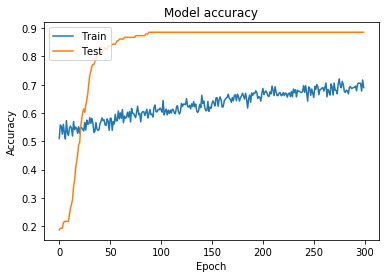

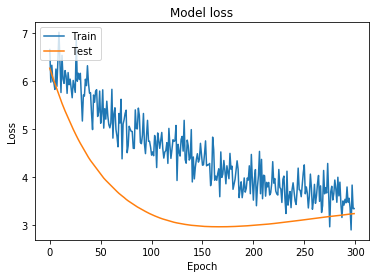

166/166 [==============================] - 3s 19ms/step
[1.617801093552486, 0.8855421543121338]


In [30]:
#Build stratified training and validation dataset
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0) 
j = 1
for train_index, test_index in sss.split(X_train, y_train):
    print('\nFold ',j)
    j +=1
    max_len = len(X)
    train_index = train_index[train_index < max_len]
    test_index = test_index[test_index < max_len]
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_valid_cv = X[train_index], X[test_index]
    y_train_cv, y_valid_cv = y[train_index], y[test_index]
    
    
    #convert y into categorical variable
    y_valid_cv = np.asarray(y_valid_cv).astype(np.int)
    y_valid_cv[y_valid_cv < 0] = 0
    y_valid_cv = to_categorical(y_valid_cv)
    y_train_cv = np.asarray(y_train_cv).astype(np.int)
    y_train_cv[y_train_cv < 0] = 0
    y_train_cv = to_categorical(y_train_cv)



    class_weight = {0: 0.15,
                   1: 0.85}
    batch_size = 64
    epochs = 300

    history = model.fit(X_train_cv,y_train_cv, batch_size=batch_size, epochs=epochs, 
                        validation_data = (X_valid_cv, y_valid_cv),
                        class_weight=class_weight)
    
    import matplotlib.pyplot as plt


    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


In [31]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_test2 = np.argmax(y_test, axis=1)

print(classification_report(y_test2, y_pred_bool))

195/195 [==============================] - 8s 43ms/step
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       176
           1       0.00      0.00      0.00        19

    accuracy                           0.90       195
   macro avg       0.45      0.50      0.47       195
weighted avg       0.81      0.90      0.86       195



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test2, y_pred_bool)

array([[176,   0],
       [ 19,   0]])